# Groningen parkeer boetes

### Hoofdoelstelling: het aantal niet-betalers minimaliseren  
Door:   zoveel mogelijk boetes uitschrijven...

Proces:
1. scan van de auto
2. beoordeling op kantoor
3. beoordeling (en boete) op lokatie       

Dataset scans: https://we.tl/t-LwszxhmMvH  
Parkeerplaatsen in groningen: https://groningen.dataplatform.nl/#/data/f0d63b83-61cb-45e6-967b-b7dfda7adf5d?totalViews=24

Analyse:  
- Tijd analyse:
    - Op welke dagen zijn er de meeste boetes? Het percentage boetes (tov het aantal meting) is zondag en zaterdag hoger dan de doordeweekse dagen
    - Worden er op dagelijks evenveel metingen gedaan? Nee, met name op zondag worden aanzienlijk minder meting gedaan.
    - Wordt er op zondag op specifieke plekken gecontroleerd ivm doordeweekse dagen?
- Wijk analyse: (wijk > buurt)
    - welke wijk heeft het hoogste % boetes. Zuidoost en centrum
    - welke wijk heeft het hoogste absolute aantal boetes. Oud-zuid, Centrum, Oud-West
    - welke wijk heeft de meeste parkeerplaatsen?
    - welke wijken worden het meest gecontroleerd?
- Buurt analyse: 
    - welke buurt heeft het hoogste % boetes
    - welke buurt heeft het hoogste absolute aantal boetes
    - welke buurt heeft de meeste parkeerplaatsen
    - welke buurten worden het meest gecontroleerd?
    
Situaties uitzoeken waar meer werd gecontroleerd (door de tijd) icm verminderde % boete. Dit zou kunnen aantonen dat meer controleren effectief is.

zijn er vast rijroutes? (en hoeveel + deze evt. visualiseren)
Pieter: bestand met aggregaties tbv

In [2]:
import urllib.request
import json
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from pathlib import Path
import statistics as stats
import datetime
%matplotlib inline

In [3]:
# variabelen
url_parkeervakken = "https://ckan.dataplatform.nl/dataset/7ff17203-0dba-40f8-9abf-1b770baa6be6/resource/ed307596-cadd-4982-821c-29856260ae2e/download/parkeervakken_gem_groningen.json"
scanfile = Path('source/Scansv2.csv')
header = "ScanIdentifier;ScanDatumTijd;Maand;Kwartaal;Jaar;Feestdag;Werkdag;WeekdagNaam;Tijdstip24;ScanType;ScanQualifierOms;ScanQualifierTypeOms;VergunningStatusCode;ScanBericht;SubbuurtCode;Subbuurt;BuurtCode;Buurt;WijkCode;Wijk;AutoVoorFiscaal;ScanSubjectLatitude;ScanSubjectLongitude;ScanAfstand;ScanParkLatitude;ScanParkLongitude;ScanBetrouwbaarheid;Boete;VoertuigType;ParkeervakID;ProcessedDatumTijd"
header_list = header.split(";")

In [5]:
# lees data van url parkeervakken en zet in dataframe
with urllib.request.urlopen(url_parkeervakken) as file:
    df_pv = json.loads(file.read().decode())
    
df_parkingspots = pd.DataFrame([feature['properties'] for feature in df_pv['features']])

In [6]:
# lees scan data
df_scan = pd.read_csv(scanfile, sep=';', decimal=",", header=None, low_memory=False) 
df_scan.columns = header_list

# Scan file EDA

In [7]:
#stats.BasicStats(df_scan)

In [8]:
df_scan.head(5)

,ScanIdentifier,ScanDatumTijd,Maand,Kwartaal,Jaar,Feestdag,Werkdag,WeekdagNaam,Tijdstip24,ScanType,...,ScanSubjectLatitude,ScanSubjectLongitude,ScanAfstand,ScanParkLatitude,ScanParkLongitude,ScanBetrouwbaarheid,Boete,VoertuigType,ParkeervakID,ProcessedDatumTijd
0,1307388,2019-04-01 09:17:12.0000000,4,2,2019,0,1,Maandag,9:17,Unknown,...,53.213249,6.568497,0.1425,53.213295,6.568580,941,0,NaN,1012240,2019-05-22 11:15:45.0000000
1,1307389,2019-04-01 09:17:14.0000000,4,2,2019,0,1,Maandag,9:17,Unknown,...,53.213329,6.568438,-0.9200,53.213352,6.568536,941,0,NaN,1012238,2019-05-22 11:15:45.0000000
2,1307390,2019-04-01 09:17:18.0000000,4,2,2019,0,1,Maandag,9:17,Unknown,...,53.213558,6.568274,-0.0525,53.213589,6.568382,943,0,NaN,1012230,2019-05-22 11:15:45.0000000
3,1307391,2019-04-01 09:17:15.0000000,4,2,2019,0,1,Maandag,9:17,Unknown,...,53.213390,6.568396,-0.0700,53.213417,6.568498,937,0,NaN,1012236,2019-05-22 11:15:45.0000000
4,1307392,2019-04-01 09:17:16.0000000,4,2,2019,0,1,Maandag,9:17,Unknown,...,53.213463,6.568342,-0.0500,53.213482,6.568442,936,0,NaN,1012233,2019-05-22 11:15:45.0000000


# Scan file data handling
1. zet kolom ScanDatumTijd naar date format
2. maak een datum kolom aan (zonder tijd)  
3. zet kolom Tijd24 naar tijd format
4. verwijder alle wijken met 0% boetes (daar valt toch niets te winnen)
5. verwijder alle buurten met 0% boetes (daar valt toch niets te winnen)

In [9]:
# 1
df_scan['ScanDatumTijd'] = pd.to_datetime(df_scan['ScanDatumTijd'], format="%Y-%m-%d %H:%M:%S.0000000")
# 2
df_scan['Datum'] = df_scan['ScanDatumTijd'].dt.date
df_scan['Datum'] = pd.to_datetime(df_scan['Datum'])
# 3
#df_scan['Tijdstip24'] = pd.to_datetime(df_scan['Tijdstip24'],format= '%H:%M' ).dt.time
df_scan['uur'] = df_scan['ScanDatumTijd'].dt.hour
# 4
a = pd.DataFrame(df_scan.groupby(by='Wijk')['Boete'].sum())==0
b = a[a['Boete']].index
df_scan = df_scan[-df_scan['Wijk'].isin(b)]
# 5
c = pd.DataFrame(df_scan.groupby(by='Buurt')['Boete'].sum())==0
d = c[c['Boete']].index
df_scan = df_scan[-df_scan['Buurt'].isin(d)]

In [10]:
def grouping(df, grouper, group):
    """
    Functie voor het maken van geaggregeerde waarden
    Voegt tevens een relatieve kolom toe
    """
    df_out = df[[grouper, group]].groupby(grouper).count().reset_index().merge(df[[grouper, group]].groupby(grouper).sum().reset_index(), on=grouper)
    df_out.columns=[grouper, 'count', 'sum']
    df_out['relative'] = (df_out['sum'] / df_out['count'])
    
    return df_out

### datum analyse

Er is gemeten van 2019-04-01 t/m 2019-10-31.  
Totaal 202 dagen

In [11]:
df_datums = grouping(df_scan, 'Datum', 'Boete')
df_datums.describe()

,count,sum,relative
count,202.000000,202.000000,202.000000
mean,9629.084158,147.841584,0.017025
std,3288.512936,60.138519,0.008210
min,1089.000000,0.000000,0.000000
25%,8427.250000,117.500000,0.012797
50%,10344.000000,145.500000,0.015078
75%,11942.250000,182.000000,0.019284
max,14626.000000,309.000000,0.047960


In [12]:
df_datums.corr()

,count,sum,relative
count,1.000000,0.527969,-0.598967
sum,0.527969,1.000000,0.249123
relative,-0.598967,0.249123,1.000000


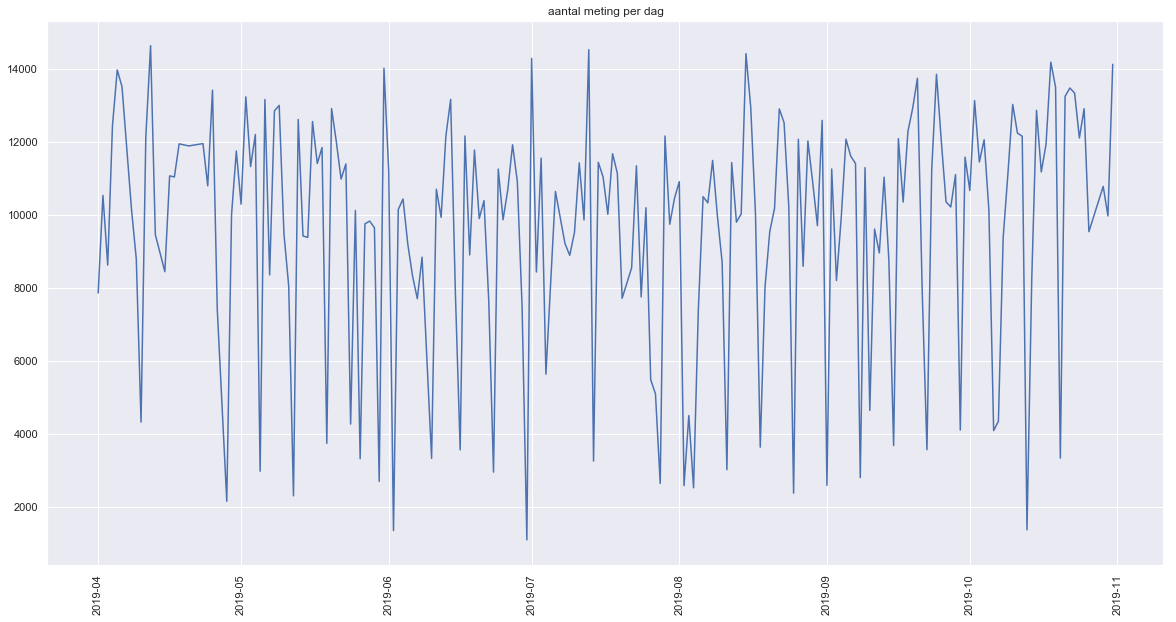

In [13]:
plt.figure(figsize=(20,10))
plt.plot(df_datums['Datum'], df_datums['count'])
plt.title('aantal meting per dag')
plt.xticks(rotation='vertical')
plt.show()

Veel structurele schommelingen. Lijken weekenden te zijn. 

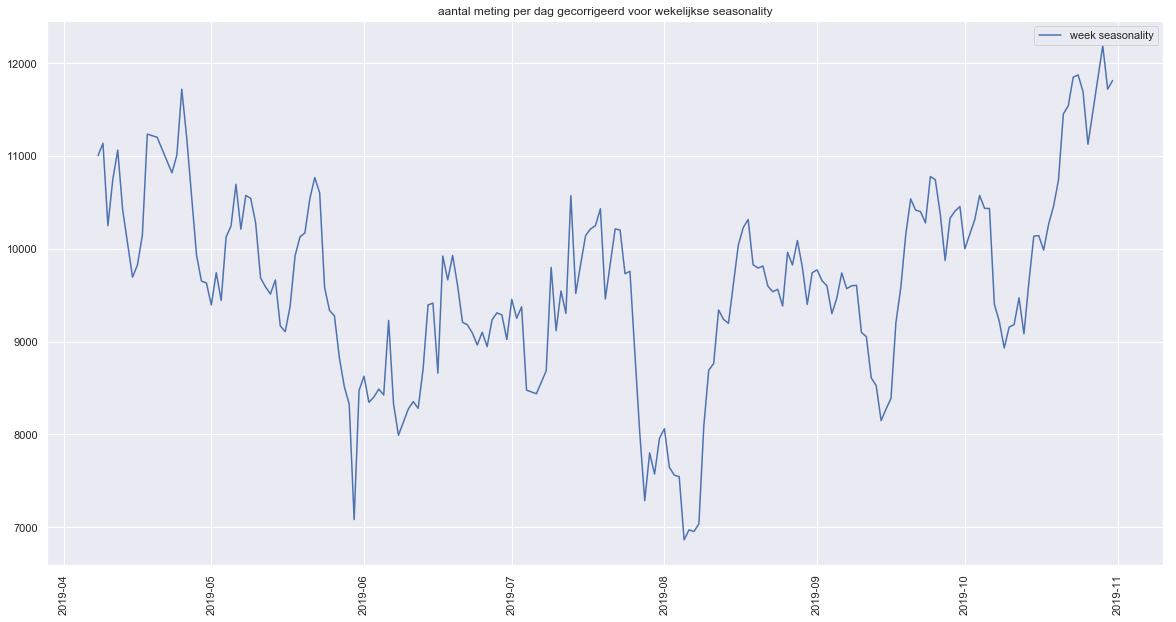

In [14]:
counts = df_datums[['Datum', 'count']].set_index(['Datum'])
fines = df_datums[['Datum', 'sum']].set_index(['Datum'])

plt.figure(figsize=(20,10))
plt.plot(counts.index, counts.rolling(7).mean(), label='week seasonality')
plt.title('aantal meting per dag gecorrigeerd voor wekelijkse seasonality')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

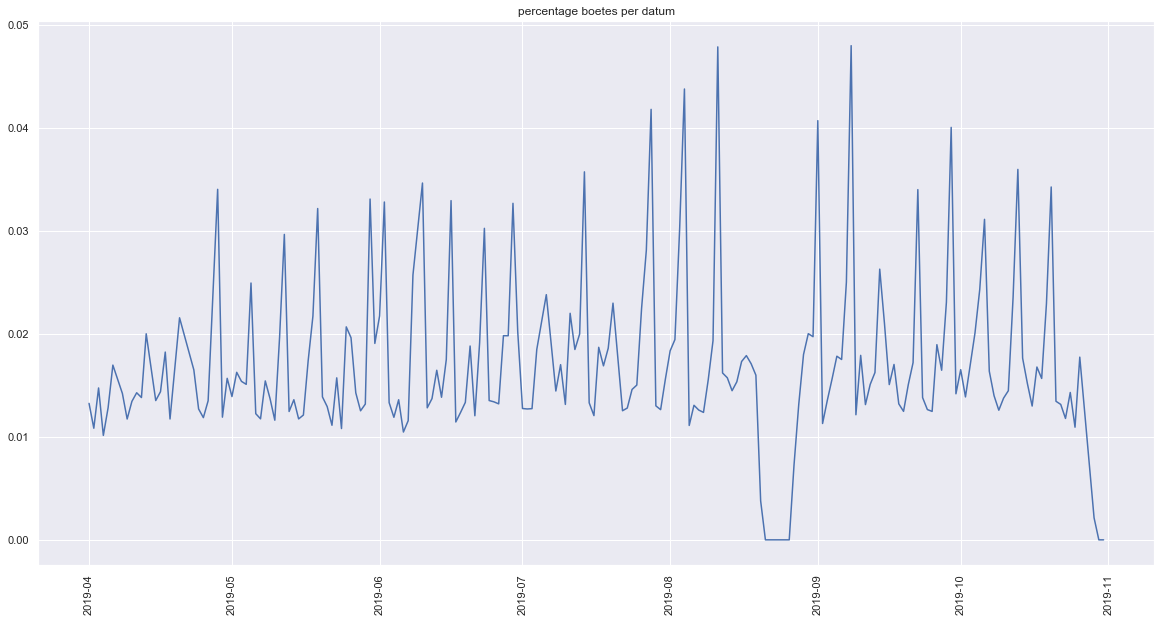

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df_datums['Datum'], df_datums['relative'])
plt.title('percentage boetes per datum')
plt.xticks(rotation='vertical')
plt.show()

In augustus en (eind) oktober zijn een aantal metingen met waarde 0. Dit is onwaarschijnlijk. De records van die dagen worden verwijderd.

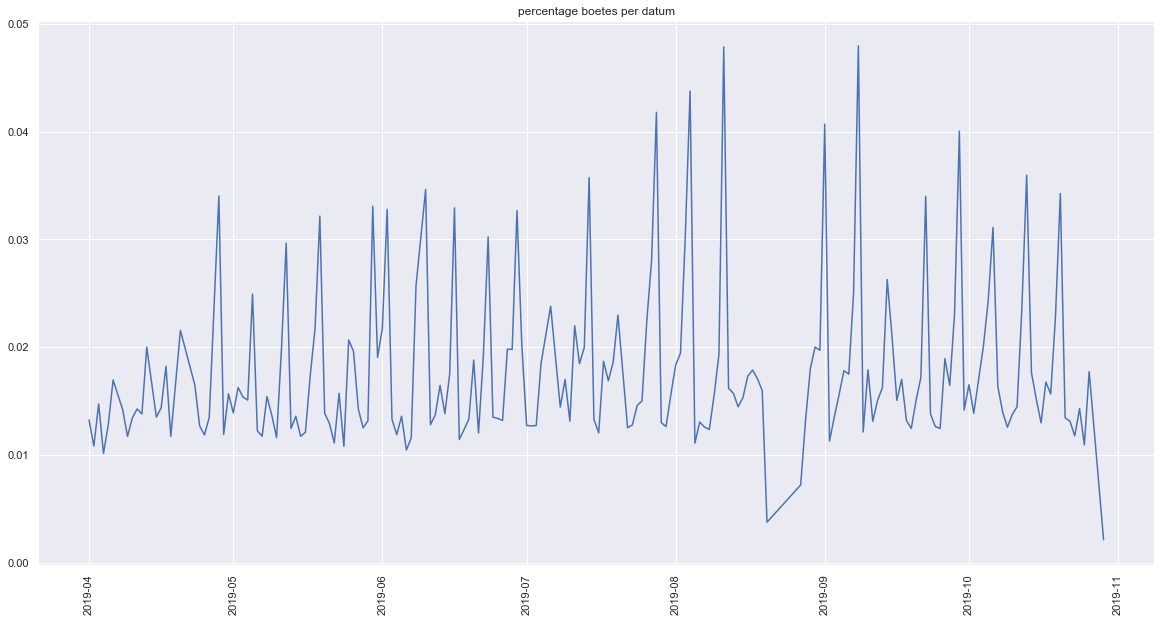

In [16]:
# verwijder datums met 0 boetes
df_scan = df_scan[-df_scan['Datum'].isin(df_datums[df_datums['sum'] == 0]['Datum'])]
df_datums = grouping(df_scan, 'Datum', 'Boete')

plt.figure(figsize=(20,10))
plt.plot(df_datums['Datum'], df_datums['relative'])
plt.title('percentage boetes per datum')
plt.xticks(rotation='vertical')
plt.show()

Onderzoeken: zijn de pieken weekenden?

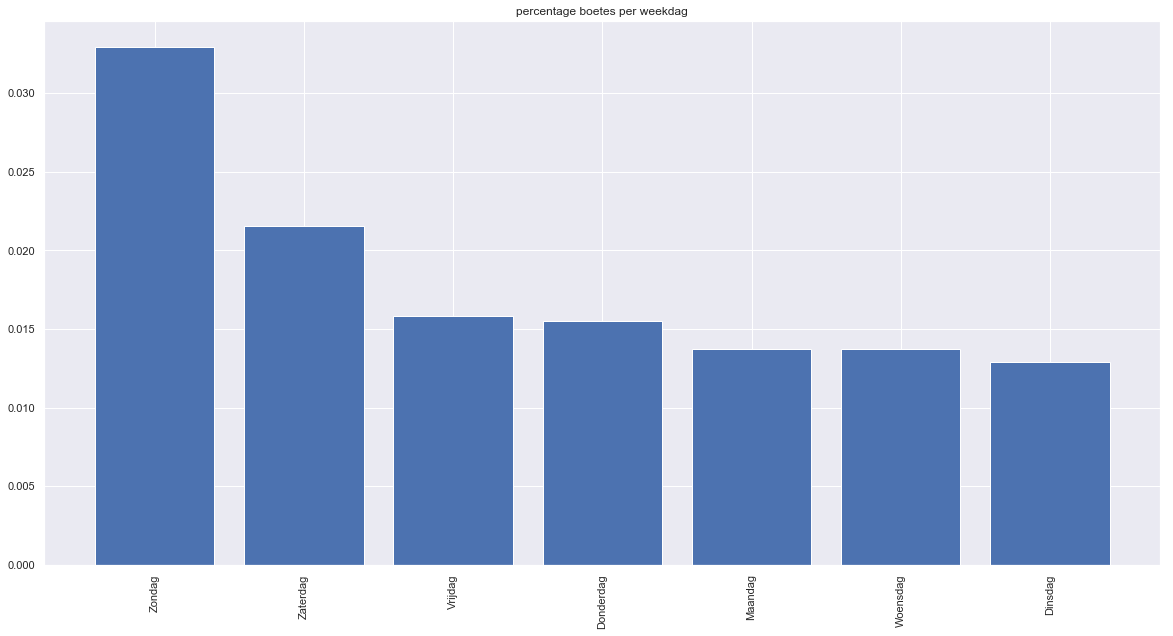

In [17]:
df_weekdagnaam = grouping(df_scan, 'WeekdagNaam', 'Boete').sort_values(by='relative', ascending=False)

plt.figure(figsize=(20,10))
plt.bar(df_weekdagnaam['WeekdagNaam'], df_weekdagnaam['relative'])
plt.title('percentage boetes per weekdag')
plt.xticks(rotation='vertical')
plt.show()

Met name op zondag en zaterdag worden relatief veel boetes gegeven. 

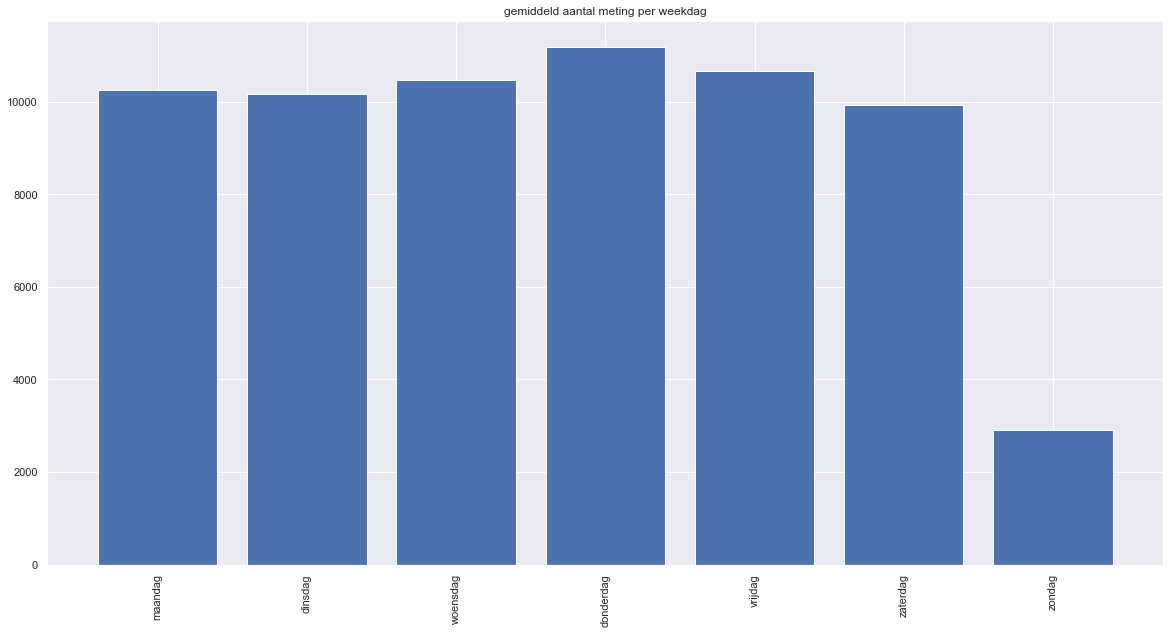

In [18]:
df = df_scan[['Datum', 'Boete']].groupby(['Datum']).count()
t = df.groupby(df.index.dayofweek)['Boete'].mean()
dagen = ['maandag', 'dinsdag', 'woensdag', 'donderdag', 'vrijdag', 'zaterdag', 'zondag']

plt.figure(figsize=(20,10))
plt.bar(dagen, t)
plt.title('gemiddeld aantal meting per weekdag')
plt.xticks(rotation='vertical')
plt.show()

Op zondag worden gemiddeld veel minder metingen gedaan. 

### Wijk analyse

In [19]:
# gemiddelde wijk coordinaten. Niet geheel zuiver maar genoeg voor op een kaart...
df_wijk_coords = df_scan[['Wijk', 'ScanSubjectLatitude','ScanSubjectLongitude']].groupby('Wijk').mean().reset_index()
df_wijk_coords

,Wijk,ScanSubjectLatitude,ScanSubjectLongitude
0,Centrum,53.219535,6.565495
1,Helpman e.o.,53.200809,6.582696
2,Noordwest,53.229093,6.552180
3,Oosterparkwijk,53.223811,6.580416
4,Oud-Noord,53.230029,6.568182
5,Oud-West,53.220607,6.551113
6,Oud-Zuid,53.209897,6.568289
7,Zuidoost,53.210494,6.582881


In [20]:
df_wijk = grouping(df_scan, 'Wijk', 'Boete').sort_values(by=['relative'], ascending=False)
df_wijk

,Wijk,count,sum,relative
7,Zuidoost,16166,436,0.026970
0,Centrum,467467,11445,0.024483
4,Oud-Noord,247987,3919,0.015803
1,Helpman e.o.,25377,401,0.015802
3,Oosterparkwijk,179367,2372,0.013224
6,Oud-Zuid,489650,6195,0.012652
5,Oud-West,360239,4292,0.011914
2,Noordwest,74544,804,0.010786


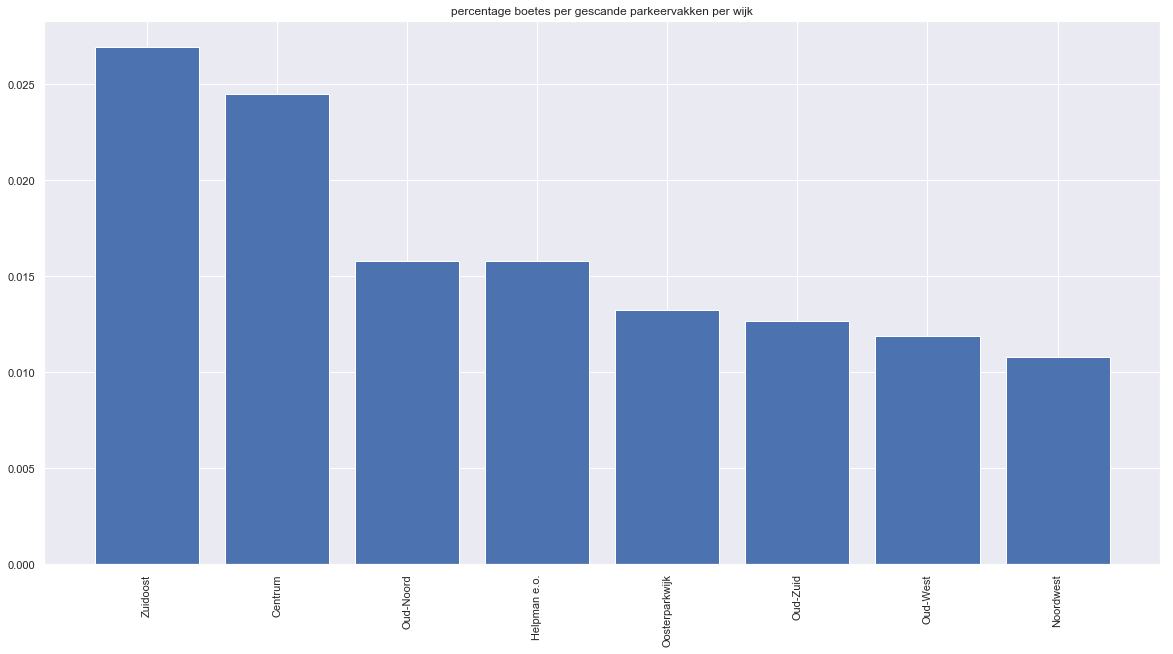

In [21]:
plt.figure(figsize=(20,10))
plt.bar(df_wijk['Wijk'], df_wijk['relative'])
plt.title('percentage boetes per gescande parkeervakken per wijk')
plt.xticks(rotation='vertical')
plt.show()

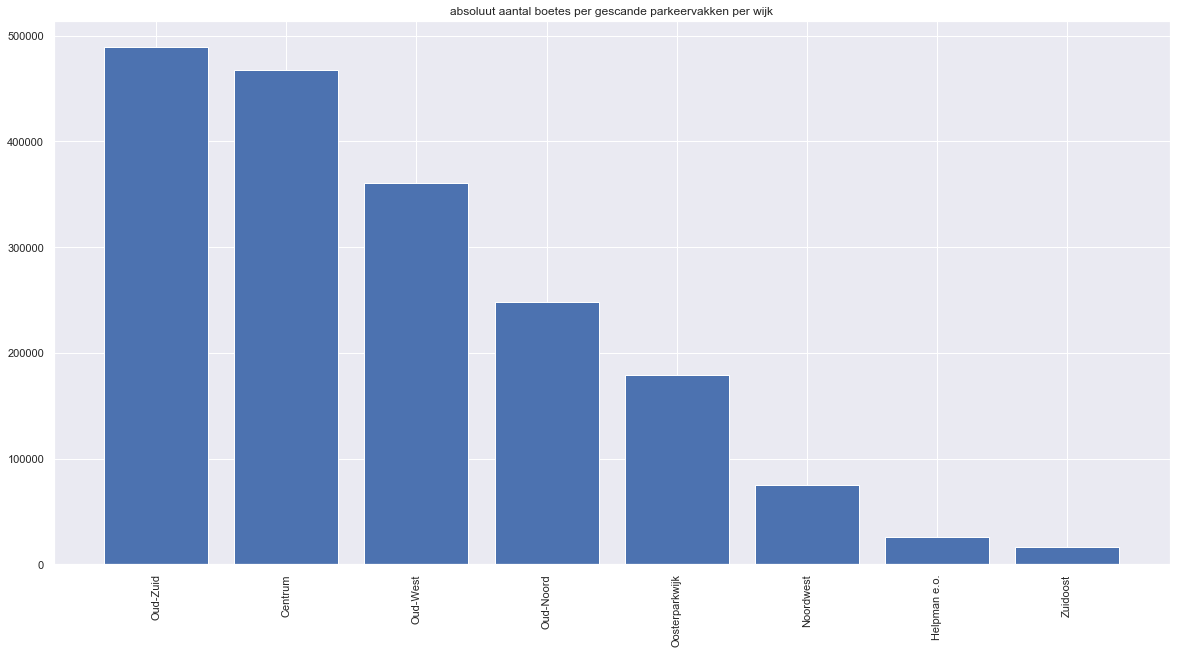

In [22]:
df_wijk.sort_values(by=['count'], ascending=False, inplace=True)

plt.figure(figsize=(20,10))
plt.bar(df_wijk['Wijk'], df_wijk['count'])
plt.title('absoluut aantal boetes per gescande parkeervakken per wijk')
plt.xticks(rotation='vertical')
plt.show()

### Buurt analyse

In [23]:
df_buurt = grouping(df_scan, 'Buurt', 'Boete').sort_values(by=['relative'], ascending=False)
df_buurt.head()

,Buurt,count,sum,relative
18,Kop van Oost,5473,340,0.062123
21,Martini Trade Park,2129,101,0.047440
11,Florabuurt,1546,66,0.042691
4,Binnenstad-Zuid,125754,4247,0.033772
1,Binnenstad-Noord,47131,1589,0.033715


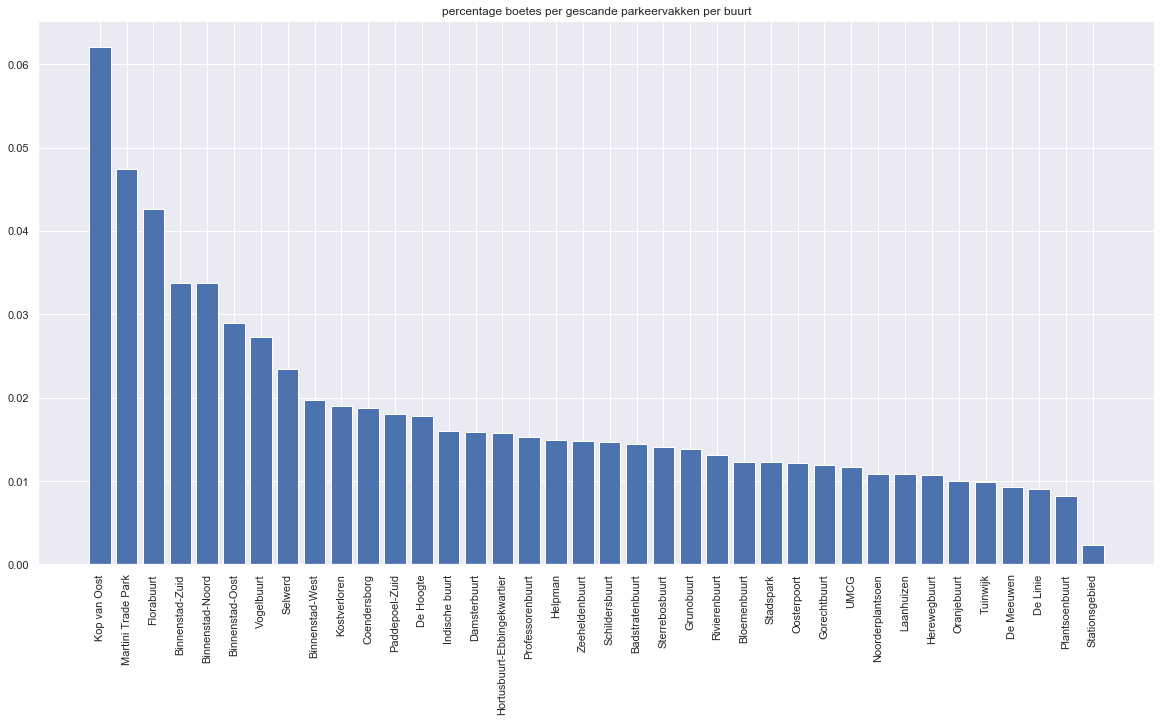

In [24]:
plt.figure(figsize=(20,10))
plt.bar(df_buurt['Buurt'], df_buurt['relative'])
plt.title('percentage boetes per gescande parkeervakken per buurt')
plt.xticks(rotation='vertical')
plt.show()

### Achterhaal de rijroute per dag

In [25]:
df_t = df_scan.sort_values(by=['Datum', 'Tijdstip24'])[['Datum', 'Buurt']].groupby(['Datum', 'Buurt'], sort=False).count().reset_index()

dict = {}
for datum in df_t['Datum'].dt.date.unique():
    dict[datum] = df_t[df_t['Datum'] == datum]['Buurt'].tolist()
    
print('totaal routes: {}'.format(len(list(dict.values()))))

C:\Users\PaulMarjanIlseMeike\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """


totaal routes: 194


In [26]:
# make tuple: ("Lists are mutable, therefore unhashable. Use tuples instead")
x = [tuple(t) for t in list(dict.values())]

print('totaal aantal unieke routes: {}'.format(len(set(x))))

totaal aantal unieke routes: 193


In [105]:
# maak numerieke mapping voor buurt en wijk
buurt_dict = {}
wijk_dict = {}

nr_buurt = df_scan['Buurt'].nunique()
buurtlist = df_scan['Buurt'].unique().tolist()

for nr, buurt in enumerate(buurtlist):
    buurt_dict[buurt] = nr

nr_wijk = df_scan['Wijk'].nunique()
wijklist = df_scan['Wijk'].unique().tolist()

for nr, wijk in enumerate(wijklist):
    wijk_dict[wijk] = nr

# voeg wijknr en buurtnr toe aan dataframe
df_scan['wijknr'] = df_scan['Wijk'].map(wijk_dict)
df_scan['buurtnr'] = df_scan['Buurt'].map(buurt_dict)

In [106]:
wijk_dict

{'Centrum': 0,
 'Oosterparkwijk': 1,
 'Oud-Noord': 2,
 'Oud-Zuid': 3,
 'Helpman e.o.': 4,
 'Noordwest': 5,
 'Oud-West': 6,
 'Zuidoost': 7}

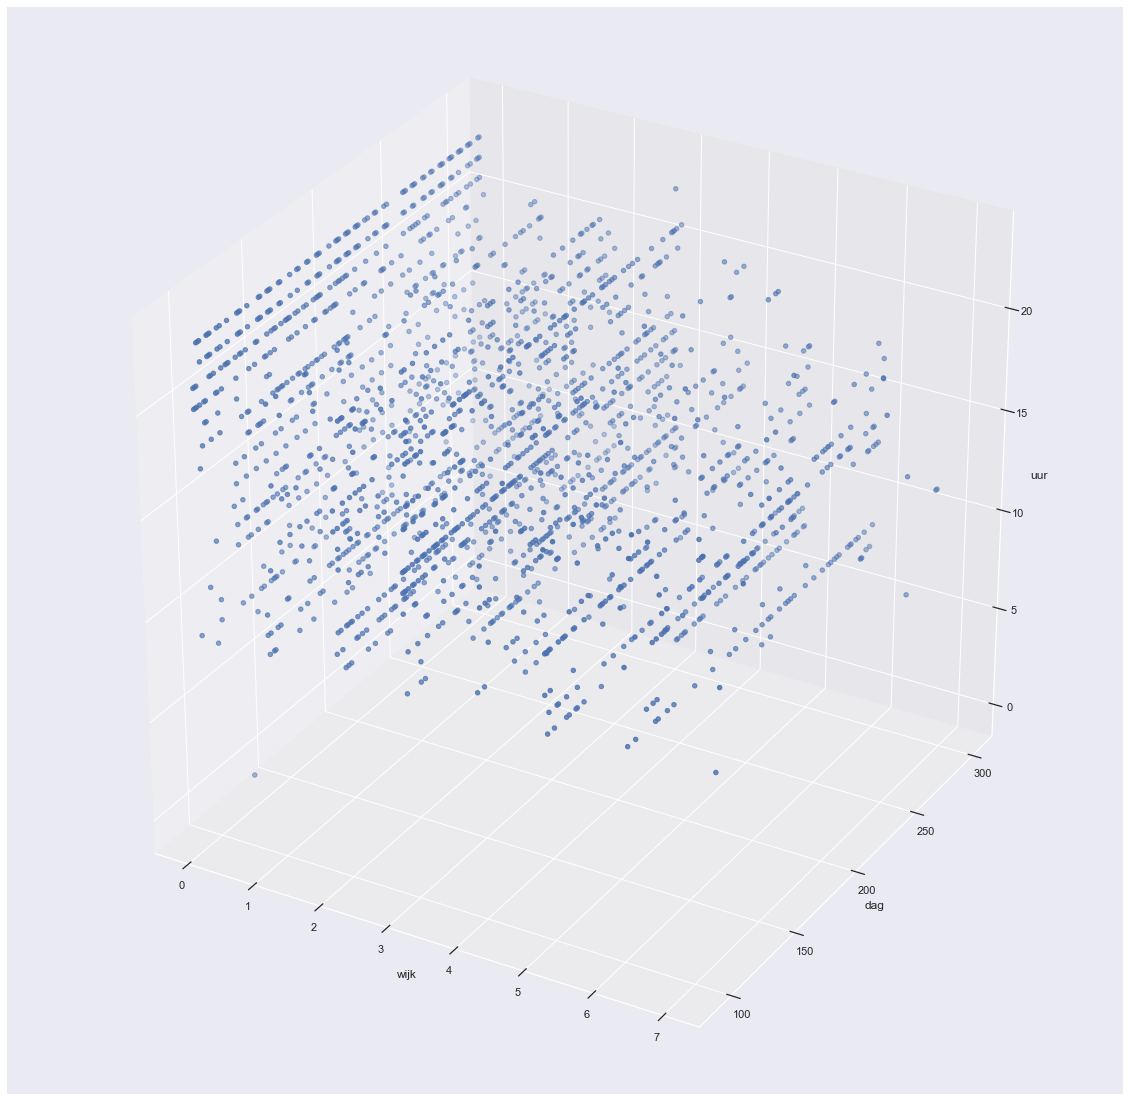

In [111]:
# maak groepering per datum, uur en wijk nr
df_array = df_scan[['Datum', 'uur', 'wijknr']].groupby(['Datum', 'uur']).mean().reset_index()
df_array['wijknr'] = df_array['wijknr'].round(0).astype(int)
# map terug naar wijk
#wijk_dict = {v: k for k, v in wijk_dict.items()}
#df_array['wijk'] = df_array['wijknr'].map(wijk_dict)
df_array['dagvanjaar'] = df_array['Datum'].dt.dayofyear

y = np.array(df_array['dagvanjaar'])
x = np.array(df_array['wijknr'])
z = np.array(df_array['uur'])

fig = plt.figure(figsize=([20,20]))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_xlabel('wijk')
ax.set_ylabel('dag')
ax.set_zlabel('uur')

plt.show()
#plt.savefig('wijk_dag_uur.png')

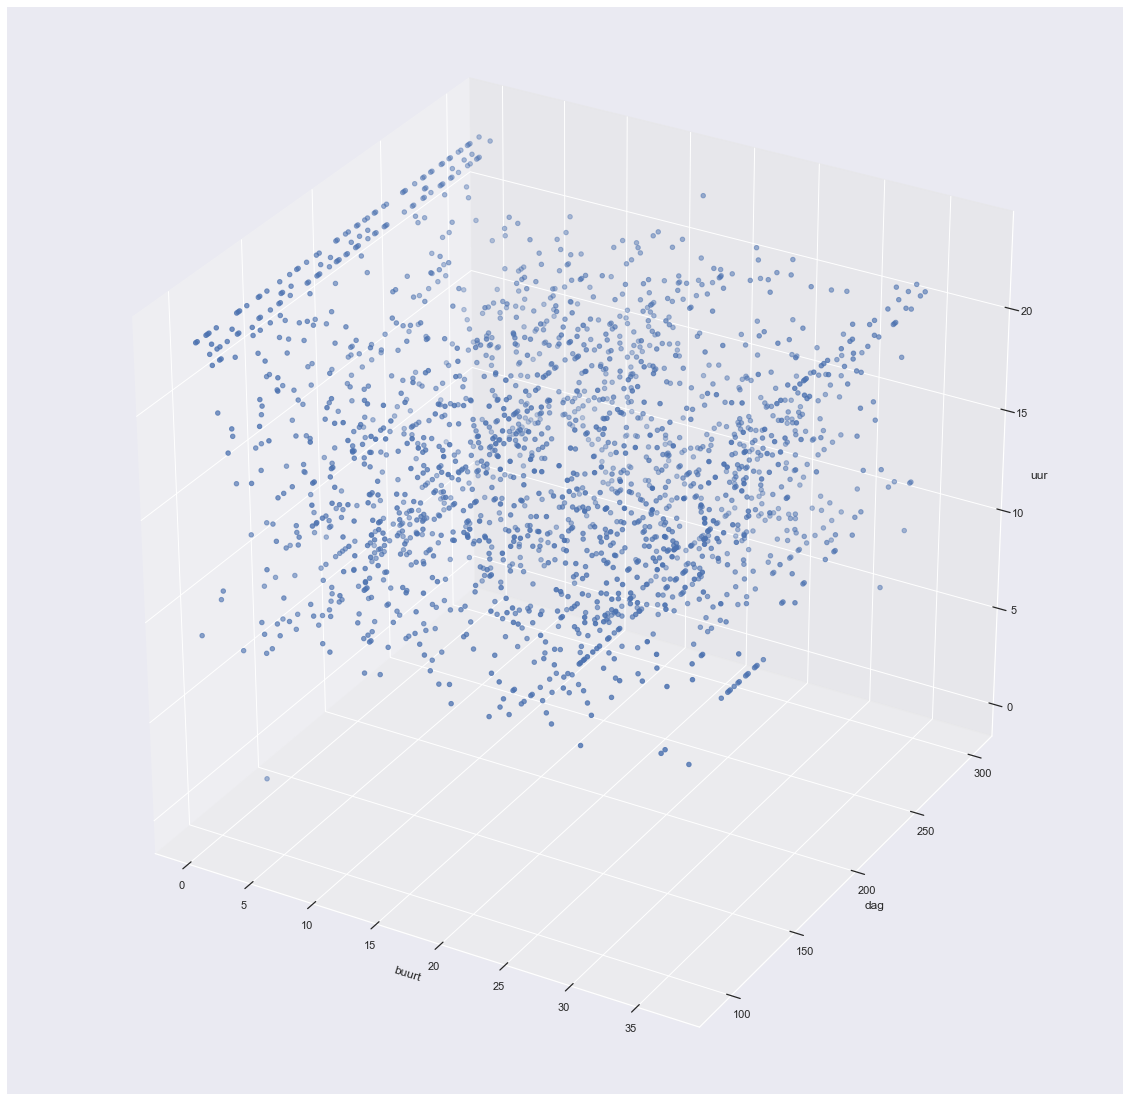

In [112]:
# per buurt
# maak groepering per datum, uur en buurt nr
df_array = df_scan[['Datum', 'uur', 'buurtnr']].groupby(['Datum', 'uur']).mean().reset_index()
df_array['buurtnr'] = df_array['buurtnr'].round(0).astype(int)
# map terug naar wijk
#wijk_dict = {v: k for k, v in wijk_dict.items()}
#df_array['wijk'] = df_array['wijknr'].map(wijk_dict)
df_array['dagvanjaar'] = df_array['Datum'].dt.dayofyear

y = np.array(df_array['dagvanjaar'])
x = np.array(df_array['buurtnr'])
z = np.array(df_array['uur'])

fig = plt.figure(figsize=([20,20]))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_xlabel('buurt')
ax.set_ylabel('dag')
ax.set_zlabel('uur')

plt.show()
#plt.savefig('buurt_dag_uur.png')

### Parking spots dataset analyses

In [27]:
# make an average coordinate out of each polygon (sum(longitude) / count(longitude))
polygons = [feature['geometry']['coordinates'] for feature in df_pv['features']]
longitude = []
latitude = []
for x in range(len(polygons)):
    t = np.array(polygons[x][0])
    longitude.append(t[:, 0].mean())
    latitude.append(t[:, 1].mean())

df_parkingspots['LONGITUDE'] = longitude
df_parkingspots['LATITUDE'] = latitude

In [28]:
stats.BasicStats(df_parkingspots)

,column,type,min,max,range,mean,stdev,populated,sum,unique,uniquelist,nulls,not applicable
0,AUTOMAATNR,int64,0.000000,4915.000000,4915.000000,3969.895920,1307.061263,17352,68885634.000000,306,,0,
1,FEATURE,string,,,,,,17352,,3,"{Parkeervak, PARKKERVAK, PARKEERVAK}",0,0
2,FUNCTIE,string,,,,,,17352,,40,too many,0,0
3,GROEP,string,,,,,,17352,,14,"{, NIET PARKEREN, K+R, BETAALD, PARTICULIER, B...",0,0
4,MAPID,int64,0.000000,567.000000,567.000000,258.241183,282.380661,17352,4481001.000000,2,,0,
5,METERID,string,,,,,,17352,,70,too many,0,0
6,MSLINK,int64,0.000000,26459.000000,26459.000000,4560.267231,6134.730459,17352,79129757.000000,7879,,0,
7,STROOKID,string,,,,,,17352,,1262,too many,0,0
8,VAKID,string,,,,,,17352,,7,"{, 11656, 11655, 11658, 11657, 11653, 11654}",0,0
9,X_COORD,float64,0.000000,235013.525000,235013.525000,108629.755387,116479.541067,17352,1884943515.470000,8039,,0,


In [29]:
df_parkingspots.head(5)

,AUTOMAATNR,FEATURE,FUNCTIE,GROEP,MAPID,METERID,MSLINK,STROOKID,VAKID,X_COORD,Y_COORD,LONGITUDE,LATITUDE
0,4531,PARKEERVAK,LADEN EN LOSSEN,LADEN EN LOSSEN,567,,21389,3625,,233136.226,581502.499,6.557059,53.214403
1,4531,PARKEERVAK,LADEN EN LOSSEN,LADEN EN LOSSEN,567,,21388,3624,,233197.150,581493.012,6.557857,53.214330
2,4515,PARKEERVAK,LADEN EN LOSSEN,LADEN EN LOSSEN,567,,17867,3054,,232900.237,581498.465,6.553373,53.214431
3,4317,PARKEERVAK,LADEN EN LOSSEN MA T/M ZA 9-18,LADEN EN LOSSEN,567,,17938,3075,,233442.333,582844.571,6.561828,53.226410
4,4058,PARKEERVAK,LADEN EN LOSSEN,LADEN EN LOSSEN,567,,3534,196,,233983.160,582115.797,6.569700,53.219823


In [30]:
for col in df_parkingspots.columns.tolist():
    if df_parkingspots[col].dtype == 'O':
        print(str(col) + ' ' + str(df_parkingspots[col].nunique()))

FEATURE 3
FUNCTIE 40
GROEP 14
METERID 70
STROOKID 1262
VAKID 7


In [31]:
df_parkingspots.groupby(by='GROEP')['GROEP'].count()

GROEP
                            978
AUTO DATE                    35
BETAALD                   15203
BUITEN ZONE                 134
ELEKTRO                      17
GERESERVEERD VOOR ARTS       13
INVALIDE ALGEMEEN           131
INVALIDE VERGUNNING         142
K+R                           1
LADEN EN LOSSEN             128
NIET PARKEREN                76
PARTICULIER                 134
TAXI                         33
VERGUNNING                  327
Name: GROEP, dtype: int64

In [40]:
df_parkingspots.groupby(by='FUNCTIE')['FUNCTIE'].count().sort_values(ascending=False)

FUNCTIE
BETAALD                                   16011
VERGUNNING                                  319
INVALIDE VERGUNNING                         151
PARTICULIER                                 139
BUITEN ZONE                                 134
INVALIDE ALGEMEEN                           111
LADEN EN LOSSEN                              79
BETAALD MA-VR 9-18 U                         61
BETAALD MA T/M ZA 18-22, NP 7-18             42
NIET MA T/M ZA                               39
AUTO DATE                                    34
ELEKTRO                                      31
TAXI                                         29
BETAALD MA T/M ZA 9-22 U                     27
LADEN EN LOSSEN MA-ZA 9.00 - 18.00           19
GERESERVEERD VOOR ARTS                       14
NP MA-ZA VAN 8-16 U                          12
LADEN EN LOSSEN MA T/M ZA 9-18               11
NIET MA T/M VR VAN 9.00 - 18.00              10
INVALIDE ALGEMEEN 18-24 U                     8
NIET MA T/M VR VAN 8.00 - 16.00 

In [33]:
# data handling
# handle FEATURE column
pvak = {'PARKEERVAK':'PARKEERVAK', 'Parkeervak':'PARKEERVAK', 'PARKKERVAK':'PARKEERVAK'}
df_parkingspots['FEATURE'] = df_parkingspots['FEATURE'].map(pvak)

### kaart van alle parkeervakken + wijk aanduiding

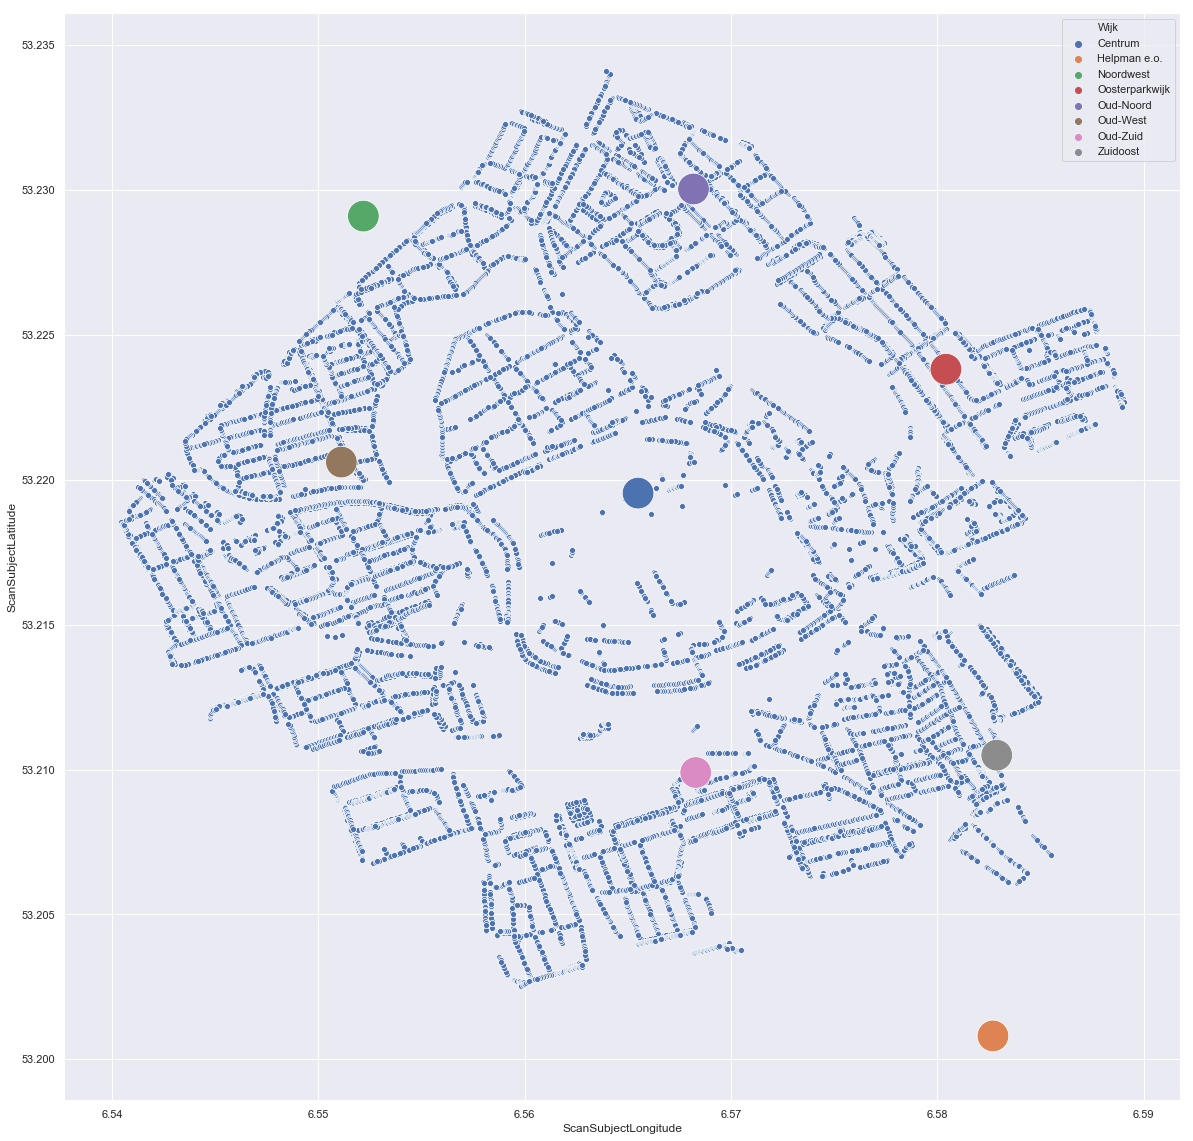

In [35]:
fig, ax = plt.subplots(figsize=(20,20))
ax2= sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=df_parkingspots[['LONGITUDE','LATITUDE']])
ax = sns.scatterplot(x="ScanSubjectLongitude", y="ScanSubjectLatitude", data=df_wijk_coords[['ScanSubjectLongitude','ScanSubjectLatitude']], s=1000, hue=df_wijk_coords['Wijk'])


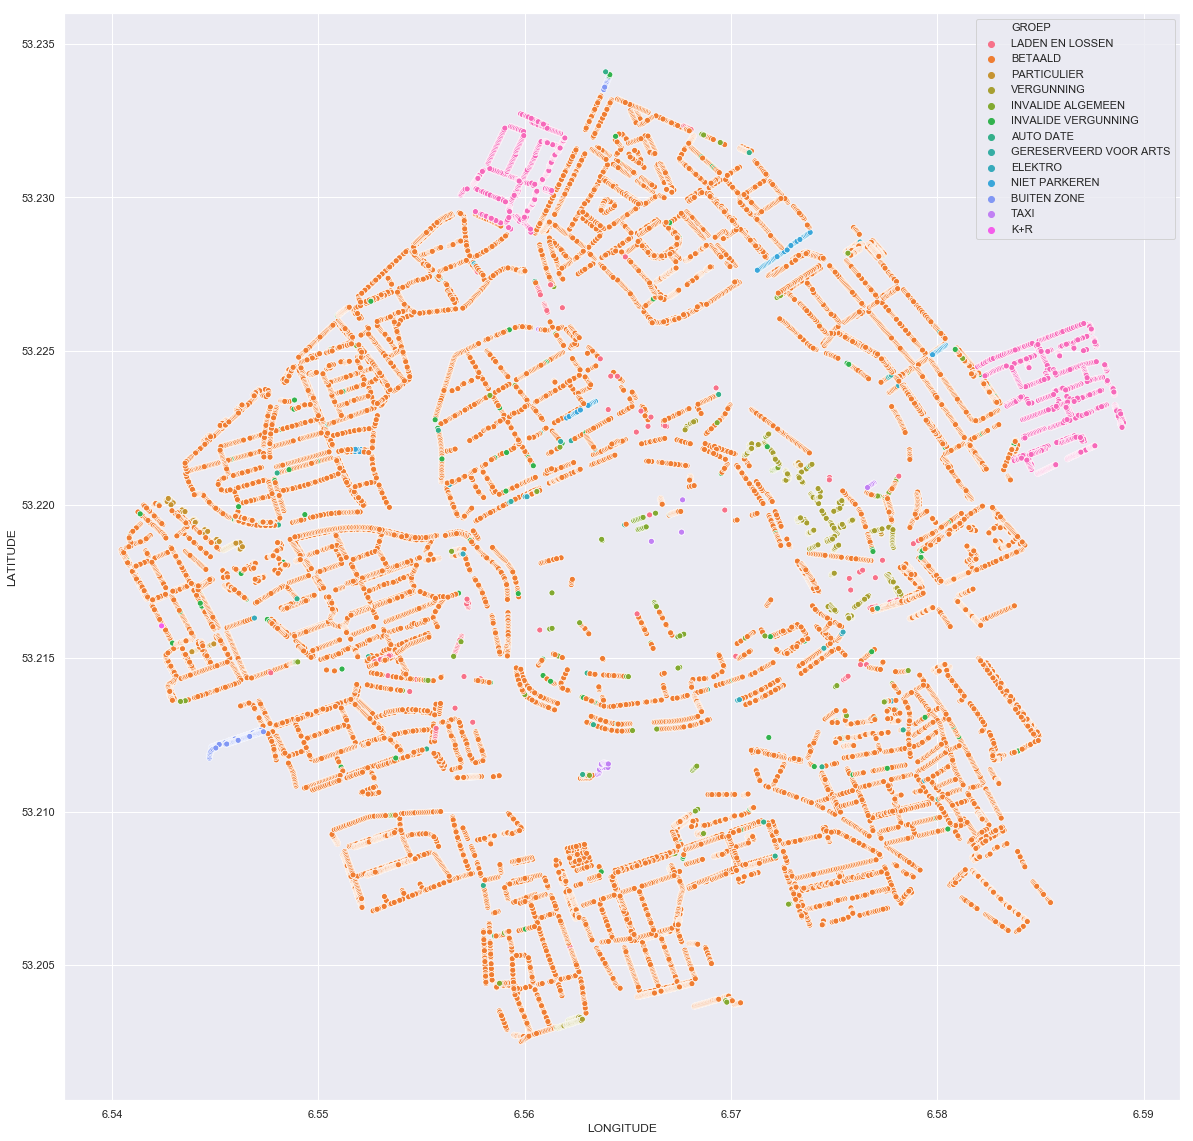

In [36]:
# make graph of all parking spots, highlight specific 'groep' item
groep = 'ELEKTRO'
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.scatterplot(x='LONGITUDE', 
                     y='LATITUDE', 
                     data=df_parkingspots[['LONGITUDE','LATITUDE']], 
                     hue=df_parkingspots['GROEP'])

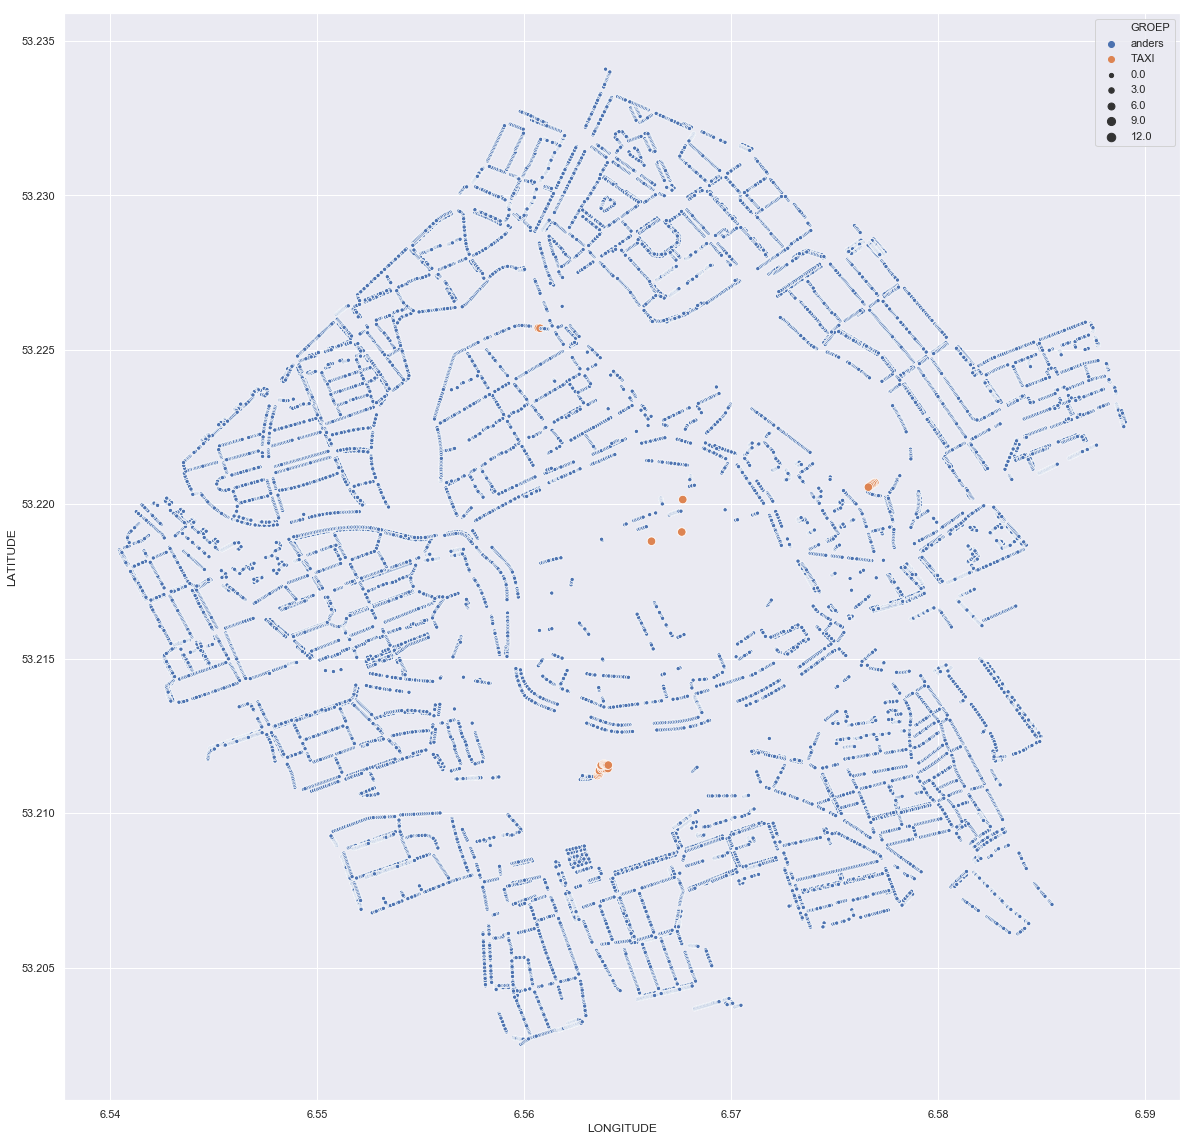

In [37]:
# make graph of all parking spots, highlight specific 'groep' item
groep = 'TAXI'
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.scatterplot(x='LONGITUDE', 
                     y='LATITUDE', 
                     data=df_parkingspots[['LONGITUDE','LATITUDE']], 
                     hue=df_parkingspots['GROEP'].map({groep: groep}).fillna('anders'),
                    size=df_parkingspots['GROEP'].map({groep: 10}).fillna(1))